In [2]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats

%load_ext autoreload
%autoreload 2

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

In [3]:
%run ./gini.py # contains gini and giniMacro
%run ./skills.py # contains subsetSkills, createCountryPenRates
%run ./fileWork.py # contains countryMerger
%run ./scatter_hist.py

In [4]:
# Set variables for rest of exercise
baseFile = '../00_originalData/li_country_industry_det_skill_2016.tsv' # individual skills
skillName = 'std_skill_name'
threshold = 0.001

In [5]:
skillPenIndustry_sk = readLimitMergeSkills(baseFile=baseFile,
                                skillName=skillName,
                                level1='industry_sk',
                                level1count='member_ct',
                                skillLevel='country_sk',
                                skillCount='skill_member_ct',
                                threshold=threshold) # at industry_sk level

Original file

   country_sk  industry_sk  skill_id             std_skill_name  hire_ct  \
0         239           96      1101            public speaking        3   
1         239           -9      1164       instructional design        3   
2         239           57      1004                 completion        3   
3         239           -9       344  administrative assistance        5   
4         239           -9      3526              water quality        0   

   skill_member_ct  member_ct  penetration_rate  hiring_rate  
0               34        192           0.17708      0.08824  
1               64      10731           0.00596      0.04688  
2              117        746           0.15684      0.02564  
3               79      10731           0.00736      0.06329  
4               35      10731           0.00326      0.00000  

Number of individual skills without censoring (beyond LI's rule of 30)
(32835,)

Skill with minimum number of global members given threshold:
penRate

In [6]:
indMap = pd.read_csv('../00_originalData/li_isic_industry_mapping.tsv', sep='\t')
indMap = indMap[indMap['industry_sk'] != -9] # not classified (-9) appears in all isici sections
indMap[indMap.duplicated(['isic_section', 'industry_sk'], keep=False)] # the mapping was done at the division level
indMap.drop_duplicates(['isic_section', 'industry_sk'], inplace=True)

firstStep = pd.read_csv(baseFile, sep='\t')
secondStep = pd.merge(firstStep,
                      indMap[['industry_sk', 'isic_section']], 
                      on='industry_sk', how='outer', indicator=True)
secondStep._merge.value_counts()
secondStep.loc[secondStep['_merge'] == 'left_only', 'isic_section'] = 'Z' # These are the missing ones industry_sk, which have no section (Z doesn't exist)
secondStep = secondStep[secondStep['_merge'] != 'right_only']
secondStep.drop('_merge', axis=1, inplace=True)

thirdStep = secondStep.drop_duplicates(['country_sk', 'industry_sk']
                                      ).groupby(['country_sk', 'isic_section'])['member_ct'
                                                                               ].sum().reset_index()

fourthStep = secondStep.groupby(['country_sk', 'isic_section', 'std_skill_name'])['skill_member_ct'].sum(
    ).reset_index()

fifthStep = pd.merge(thirdStep, fourthStep, on=['country_sk', 'isic_section'])

fifthStep.to_csv('../02_data/li_country_industry_det_skill_2016_byISICsection.tsv', sep='\t', index=False, header=True)

thirdStep.drop_duplicates(['country_sk', 'isic_section'])['member_ct'].sum()
fifthStep.drop_duplicates(['country_sk', 'industry_sk'])['member_ct'].sum()

skillPenIsicSection = readLimitMergeSkills(
    baseFile='../02_data/li_country_industry_det_skill_2016_byISICsection.tsv',
    skillName=skillName, 
    level1='isic_section', 
    level1count='member_ct', 
    skillLevel='country_sk',
    skillCount='skill_member_ct',
    threshold=threshold) # at industry_sk level

subsetSkills = pd.DataFrame(skillPenIsicSection.idxmax()).reset_index().rename(columns={0 : 'isic_section'})
subsetSkills.shape
# NOT in li skill data for 2016
#isic_section	isic_section_name	isic_division	isic_division_name	industry_name	Industry_group_sk	Industry_group_name	_merge
#F	Construction	43	Specialized construction activities	Not_mapped	4	Construction	right_only

,isic_section,isic_section_name,isic_division,isic_division_name,industry_sk,industry_name,Industry_group_sk,Industry_group_name
5,B,Mining and quarrying,5,Mining of coal and lignite,56.0,mining & metals,16,Energy and Mining
7,B,Mining and quarrying,7,Mining of metal ores,56.0,mining & metals,16,Energy and Mining
8,B,Mining and quarrying,8,Other mining and quarrying,56.0,mining & metals,16,Energy and Mining
9,B,Mining and quarrying,9,Mining support service activities,56.0,mining & metals,16,Energy and Mining
10,C,Manufacture,10,Manufacture of food products,23.0,food production,10,Manufacturing
11,C,Manufacture,11,Manufacture of beverages,23.0,food production,10,Manufacturing
25,C,Manufacture,25,"Manufacture of fabricated metal products, exce...",2.0,defense and space,10,Manufacturing
26,C,Manufacture,26,"Manufacture of computer, electronic and optica...",112.0,electrical and electronic manufacturing,10,Manufacturing
27,C,Manufacture,27,Manufacture of electrical equipment,112.0,electrical and electronic manufacturing,10,Manufacturing
33,C,Manufacture,30,Manufacture of other transport equipment,2.0,defense and space,10,Manufacturing


both          1995923
left_only      461430
right_only          1
Name: _merge, dtype: int64

116271142.0

224341.0

Original file

   country_sk isic_section  member_ct          std_skill_name  skill_member_ct
0         2.0            A      488.0      account management             48.0
1         2.0            A      488.0  account reconciliation             31.0
2         2.0            A      488.0              accounting             36.0
3         2.0            A      488.0               budgeting             41.0
4         2.0            A      488.0    business development            100.0

Number of individual skills without censoring (beyond LI's rule of 30)
(32835,)

Skill with minimum number of global members given threshold:
penRate    116367.0
dtype: float64

Skills after limiting to  0.001
(1582,)


(1582, 2)

In [7]:
subsetSkills = subsetSkills[(subsetSkills['isic_section'] == 'J') |
                            (subsetSkills['isic_section'] == 'K') |
                            (subsetSkills['isic_section'] == 'M')]
subsetSkills.shape
subsetSkills.to_csv('../02_data/subsetSkillKnowledge.csv', header=True, index=False)

(586, 2)

In [10]:
skillPen = skillPenIndustry_sk[subsetSkills['std_skill_name']]
skillPen.shape

(148, 586)

count    586.000000
mean       0.727945
std        0.143826
min        0.278621
25%        0.622375
50%        0.750477
75%        0.839361
max        0.974918
dtype: float64


std_skill_name
quickbooks                 0.278621
windows                    0.294631
database administration    0.337950
marketing                  0.367977
sharepoint                 0.370525
dtype: float64

std_skill_name
private banking                        0.959153
synchronous digital hierarchy (sdh)    0.962014
tax advisory                           0.963859
mixed-use                              0.966017
2g                                     0.974918
dtype: float64

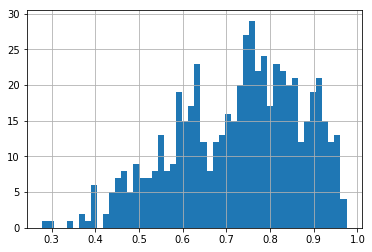

In [11]:
giniCoeffIndustry = pd.Series(index=skillPen.columns)
for i in np.arange(0, skillPen.shape[1]):
    giniCoeffIndustry.iloc[i] = gini(skillPen[skillPen.columns[i]].values)
giniCoeffIndustry = giniCoeffIndustry.sort_values()    
print(giniCoeffIndustry.describe())
giniCoeffIndustry.hist(bins=50)
giniCoeffIndustry.head()
giniCoeffIndustry.tail()

Original file

   country_sk  industry_sk  skill_id             std_skill_name  hire_ct  \
0         239           96      1101            public speaking        3   
1         239           -9      1164       instructional design        3   
2         239           57      1004                 completion        3   
3         239           -9       344  administrative assistance        5   
4         239           -9      3526              water quality        0   

   skill_member_ct  member_ct  penetration_rate  hiring_rate  
0               34        192           0.17708      0.08824  
1               64      10731           0.00596      0.04688  
2              117        746           0.15684      0.02564  
3               79      10731           0.00736      0.06329  
4               35      10731           0.00326      0.00000  

Number of individual skills without censoring (beyond LI's rule of 30)
(32835,)

Skill with minimum number of global members given threshold:
penRate

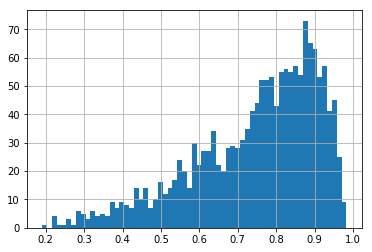

In [12]:
giniCoeff = giniMacro(baseFile=baseFile,
                      skillName=skillName,
                      level1='industry_sk',
                      skillLevel='country_sk',
                      threshold=threshold)

In [13]:
giniCoeff.head(25)
giniCoeff.tail(25)

std_skill_name
leadership                   0.190358
microsoft word               0.220194
microsoft office             0.221193
microsoft powerpoint         0.223714
microsoft outlook            0.228024
microsoft excel              0.239036
problem solving              0.241921
customer service             0.253850
microsoft access             0.264207
administrative assistance    0.265672
office administration        0.267891
quickbooks                   0.278621
management                   0.279156
strategic planning           0.282409
communication                0.283477
mentoring                    0.286976
training                     0.288443
windows                      0.294631
teamwork                     0.296917
public speaking              0.298023
team building                0.300802
administration               0.302172
spreadsheets                 0.310359
time management              0.312168
interpersonal skills         0.312813
dtype: float64

std_skill_name
linguistics                            0.961091
opera                                  0.961288
synchronous digital hierarchy (sdh)    0.962014
rail transport                         0.963538
tax advisory                           0.963859
food science                           0.964353
computer animation                     0.964670
ocean transportation                   0.965328
mixed-use                              0.966017
international shipping                 0.966262
hotel booking                          0.966500
pharmacovigilance                      0.967131
metallurgy                             0.967143
petroleum engineering                  0.968104
veterinary medicine                    0.968919
character animation                    0.970097
maritime                               0.971706
2g                                     0.974918
minerals                               0.975159
rooms division                         0.977646
airworthiness            

In [14]:
gdppcPPP = pd.read_csv('../00_originalData/API_NY.GDP.PCAP.PP.CD_DS2_en_csv_v2.csv', skiprows=4)
gdppcPPP = gdppcPPP[['Country Name', 'Country Code', '2016']].dropna()
gdppcPPP.rename(columns={'2016':'gdppcppp2016'}, inplace=True)

giniCoeffCountry = pd.read_csv('../02_data/giniSkillByCountry.csv').set_index('std_skill_name')

In [15]:
# Set variables for rest of exercise
skillPenCountry = readLimitMergeSkills(baseFile=baseFile,
                                skillName=skillName,
                                threshold=threshold)

merger = countryMerger()

Original file

   country_sk  industry_sk  skill_id             std_skill_name  hire_ct  \
0         239           96      1101            public speaking        3   
1         239           -9      1164       instructional design        3   
2         239           57      1004                 completion        3   
3         239           -9       344  administrative assistance        5   
4         239           -9      3526              water quality        0   

   skill_member_ct  member_ct  penetration_rate  hiring_rate  
0               34        192           0.17708      0.08824  
1               64      10731           0.00596      0.04688  
2              117        746           0.15684      0.02564  
3               79      10731           0.00736      0.06329  
4               35      10731           0.00326      0.00000  

Number of individual skills without censoring (beyond LI's rule of 30)
(32835,)

Skill with minimum number of global members given threshold:
penRate

In [16]:
merged = pd.merge(merger, skillPenCountry, left_on='country_sk', right_index=True, how='inner'
                 ).set_index('iso3').drop(['country', 'country_sk'], axis=1)
# loses 169, desired

merged = pd.merge(merged, gdppcPPP.set_index('Country Code'),
                  right_index=True, left_index=True, how='inner')

In [17]:
skillGdppcppp2016 = pd.Series(merged.drop(['Country Name', 'gdppcppp2016'], axis=1
                                         ).T.dot(merged['gdppcppp2016']))
skillDenom = pd.Series(merged.drop(['Country Name', 'gdppcppp2016'], axis=1).sum(axis=0))

skillGdppcppp2016 = skillGdppcppp2016 / skillDenom
skillGdppcppp2016 = skillGdppcppp2016.sort_values()
skillGdppcppp2016.head(20)
skillGdppcppp2016.tail(20)

capacity building                         8709.572676
program evaluation                       10277.232490
non-governmental organizations (ngos)    10920.102153
international development                11892.333140
community development                    11958.735121
minerals                                 12388.662524
proposal writing                         13014.790988
mining                                   14848.164659
agriculture                              15265.925908
economic development                     15397.028899
human rights                             15742.004337
agribusiness                             15922.161472
program development                      16042.930991
computer maintenance                     16080.012119
dos                                      16725.018752
preaching                                16797.955546
nonprofit organizations                  17371.636366
2g                                       17459.657238
discipleship                

wealth management                       50768.075462
derivatives                             51424.926482
fixed income                            52663.080703
u.s. federal housing authority (fha)    52838.296100
investment management                   52987.698115
options                                 53052.698056
trading systems                         53637.312877
bonds                                   53967.844023
cpm scheduling                          54401.112548
building services                       54435.853933
revenue cycle                           54847.178890
securities                              55167.650150
private banking                         55370.691919
bloomberg                               55604.566064
epic systems                            56060.629826
structured finance                      56116.827317
asset allocation                        57127.312846
mutual funds                            60840.185486
alternative investments                 62375.

In [18]:
empl = pd.read_csv('../00_originalData/API_SL.EMP.TOTL.SP.ZS_DS2_en_csv_v2.csv', skiprows=4)
empl = empl[['Country Name', 'Country Code', '2016']].dropna()
empl.rename(columns={'2016':'empl2016'}, inplace=True)

giniCoeffCountry = pd.read_csv('../02_data/giniSkillByCountry.csv')

In [19]:
merged = pd.merge(merger, skillPenCountry, left_on='country_sk', right_index=True, how='inner'
                 ).set_index('iso3').drop(['country', 'country_sk'], axis=1)
# loses 169, desired

merged = pd.merge(merged, empl.set_index('Country Code'),
                  right_index=True, left_index=True, how='inner')

In [20]:
skillEmpl2016 = pd.Series(merged.drop(['Country Name', 'empl2016'], axis=1
                                         ).T.dot(merged['empl2016']))
skillDenom = pd.Series(merged.drop(['Country Name', 'empl2016'], axis=1).sum(axis=0))

skillEmpl2016 = skillEmpl2016 / skillDenom
skillEmpl2016 = skillEmpl2016.sort_values()

skillEmpl2016.head(20)
skillEmpl2016.tail(20)

tactics                                    50.653551
force protection                           50.975157
change control                             51.034975
italian                                    51.139446
military logistics                         51.239105
government contracting                     51.319863
european union                             51.524651
trial practice                             51.614225
cancer                                     51.644656
counterterrorism                           51.691495
weapons handling                           51.730600
corrective and preventive action (capa)    51.742701
catia                                      51.814559
neurology                                  51.846580
simulink                                   51.881038
pharmaceutics                              51.886486
army                                       51.986996
hospital sales                             52.015559
managed care                               52.

philanthropy              60.900259
climate change            60.910359
stata                     61.103974
program development       61.353695
stakeholder engagement    61.388970
plant maintenance         61.656262
building services         61.751996
community engagement      61.797723
community development     61.983895
religion                  62.198892
minerals                  62.208154
mining                    62.250576
community organizing      62.380879
program evaluation        62.386828
theology                  62.436010
biblical studies          62.516970
youth ministry            62.523821
pastoral care             62.917219
preaching                 63.408798
discipleship              63.462724
dtype: float64

In [21]:
skillGdppcppp2016[subsetSkills['std_skill_name']].sort_values().head(20)
skillGdppcppp2016[subsetSkills['std_skill_name']].sort_values().tail(20)
skillEmpl2016[subsetSkills['std_skill_name']].sort_values().head(20)
skillEmpl2016[subsetSkills['std_skill_name']].sort_values().tail(20)

std_skill_name
2g                                                   17459.657238
data structures                                      18260.610326
bootstrap                                            19553.008124
gsm                                                  19611.310824
3g                                                   19616.167844
network administration                               20203.117736
computer network operations                          20313.852585
business process outsourcing (bpo)                   20522.105658
quickbooks                                           20596.129609
joomla                                               21078.159501
mysql                                                21386.243655
ajax                                                 21417.160253
json                                                 21420.138022
object-oriented programming (oop)                    21696.855008
php                                                  21791.63

std_skill_name
securities regulation            48392.306015
equities                         48523.148893
asset management                 48755.678930
private equity                   49047.333961
foreign exchange (fx) options    49145.430057
wealth management                50768.075462
derivatives                      51424.926482
fixed income                     52663.080703
investment management            52987.698115
options                          53052.698056
trading systems                  53637.312877
bonds                            53967.844023
securities                       55167.650150
private banking                  55370.691919
bloomberg                        55604.566064
structured finance               56116.827317
asset allocation                 57127.312846
mutual funds                     60840.185486
alternative investments          62375.662433
hedge funds                      62393.542748
dtype: float64

std_skill_name
trial practice                       51.614225
vhdl                                 52.530856
microcontrollers                     52.581364
data structures                      52.968989
unified modeling language (uml)      53.117656
eclipse                              53.389006
language integrated query (linq)     53.439161
rendering                            53.516160
product liability                    53.543120
object-oriented programming (oop)    53.602420
autocad architecture                 53.654539
trials                               53.681111
json                                 53.762016
visual studio                        53.799215
soap                                 53.802388
quarkxpress                          53.812915
bankruptcy                           53.846390
urban design                         53.853047
transact-sql (t-sql)                 53.884931
westlaw                              53.914638
dtype: float64

std_skill_name
integrated circuits (ic)                58.900514
managerial finance                      58.916483
private equity                          58.971719
emerging markets                        58.972312
quickbooks                              58.973795
general ledger                          58.985163
system architecture                     58.991596
infrastructure                          59.039330
semiconductors                          59.056000
vendor management                       59.167791
management accounting                   59.169808
enterprise risk management              59.181722
analytics                               59.193147
equity research                         59.364325
management information systems (mis)    59.622527
venture capital                         59.651633
business relationship management        59.886070
treasury management                     59.897504
bank reconciliation                     60.392688
failure analysis                   


Slope of cubic at empl = 56 %: 1340.04081326


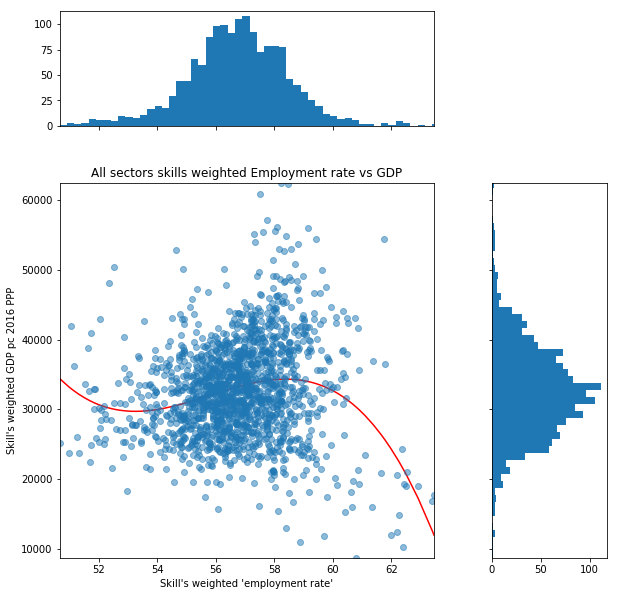

In [27]:
%run ./scatter_hist.py
scatterHist(x=skillEmpl2016,
            y=skillGdppcppp2016, 
            title="All sectors skills weighted Employment rate vs GDP",
            figSave='../04_shared/skillsGDPvsEmpl.png')


Slope of cubic at empl = 56 %: 3397.56490959


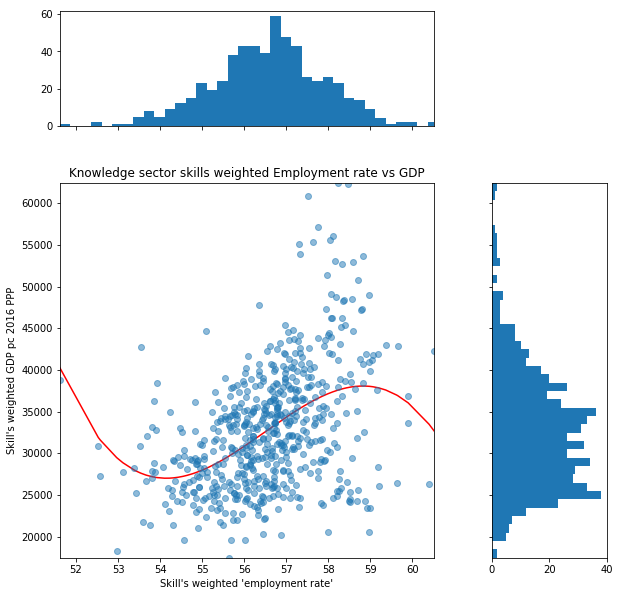

In [29]:
%run ./scatter_hist.py
scatterHist(x=skillEmpl2016[subsetSkills['std_skill_name']],
            y=skillGdppcppp2016[subsetSkills['std_skill_name']], 
            title="Knowledge sector skills weighted Employment rate vs GDP",
            figSave='../04_shared/skillsGDPvsEmpl_Knowledge.png')


Slope of cubic at empl = 56 %: 1340.04081326

Slope of cubic at empl = 56 %: 3397.56490959


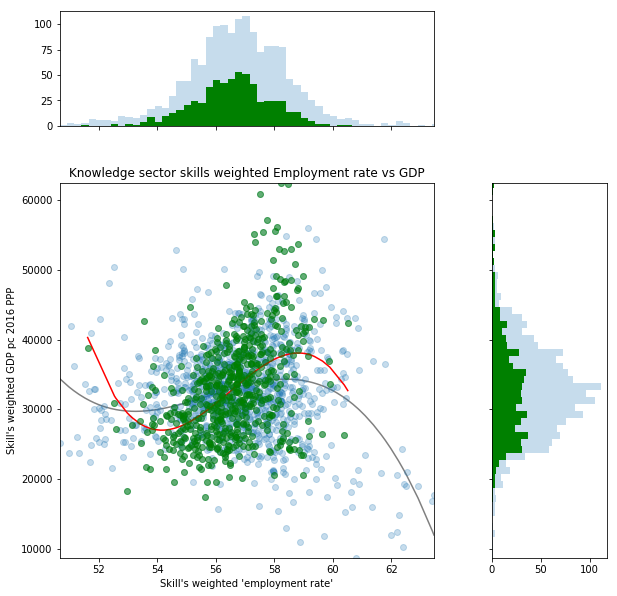

In [33]:
%run ./scatter_hist.py
doubleScatterHist(x=skillEmpl2016, y=skillGdppcppp2016,
            x2=skillEmpl2016[subsetSkills['std_skill_name']],
            y2=skillGdppcppp2016[subsetSkills['std_skill_name']], 
            title="Knowledge sector skills weighted Employment rate vs GDP",
            figSave='../04_shared/skillsGDPvsEmpl_Knowledge.png')

In [34]:
dfAll = pd.merge(giniCoeffCountry.set_index('std_skill_name'), 
              pd.DataFrame(giniCoeff).rename(columns={0 : 'skillGiniIndustry'}), 
              left_index=True, right_index=True, how='inner')
dfAll = pd.merge(dfAll, 
              pd.DataFrame(skillGdppcppp2016).rename(columns={0 : 'gdpPcPpp2016'}),
              left_index=True, right_index=True, how='inner')

[Text(0,0.5,"Skill's weighted GDP pc 2016 ppp"),
 Text(0.5,0,"Skill's Gini coefficient by Industry"),
 Text(0.5,1,'All sectors skills weighted GDP per capita vs Gini by Industry and by Country')]

Text(0,0.5,"Skill's Gini coefficient by country")

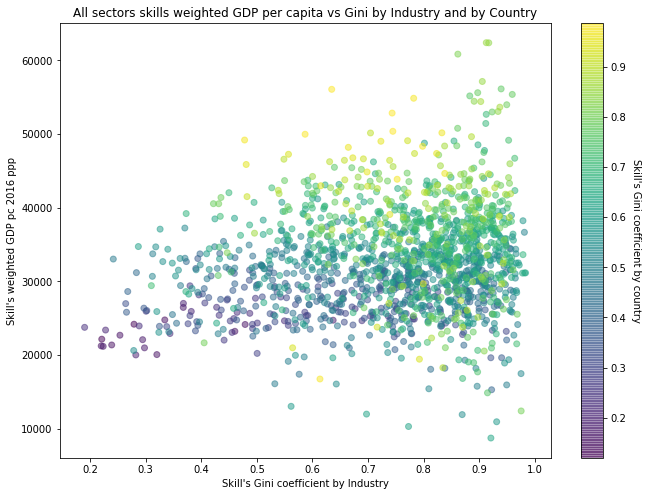

In [35]:
x, xlab = (dfAll['skillGiniIndustry'], "Skill's Gini coefficient by Industry")
y, ylab = (dfAll['gdpPcPpp2016'], "Skill's weighted GDP pc 2016 ppp")
z, zlab = (dfAll['skillGiniCountry'], "Skill's Gini coefficient by country")

fig, ax = plt.subplots(1, figsize=(11, 8))

image = ax.scatter(x, y, alpha=0.5,
          c=z, cmap='viridis')
ax.set(xlabel=xlab,
      ylabel=ylab,
      title="All sectors skills weighted GDP per capita vs Gini by Industry and by Country")


cbar = fig.colorbar(image, ax=ax)
cbar.ax.get_yaxis().labelpad = 15
cbar.ax.set_ylabel(zlab, rotation=270)
fig.savefig('../04_shared/ginisGdpPlot_countrybar_all.png',bbox_inches='tight')
plt.show()

[Text(0,0.5,"Skill's weighted GDP pc 2016 ppp"),
 Text(0.5,0,"Skill's Gini coefficient by country"),
 Text(0.5,1,"All sectors' skills weighted GDP per capita vs Gini by Industry and by Country")]

Text(0,0.5,"Skill's Gini coefficient by Industry")

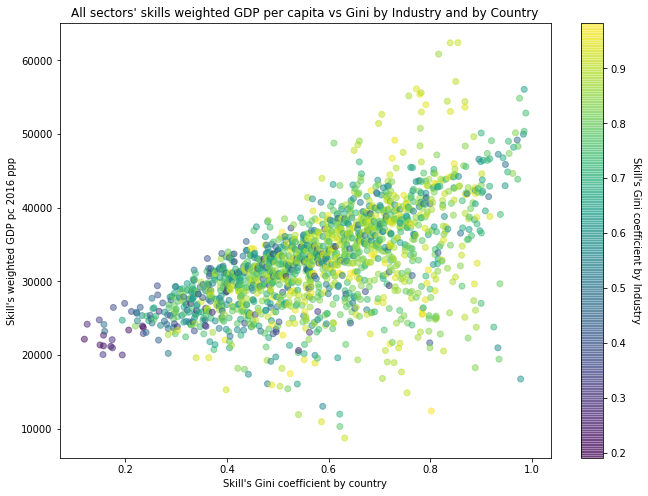

In [36]:
x, xlab = (dfAll['skillGiniCountry'], "Skill's Gini coefficient by country")
y, ylab = (dfAll['gdpPcPpp2016'], "Skill's weighted GDP pc 2016 ppp")
z, zlab = (dfAll['skillGiniIndustry'], "Skill's Gini coefficient by Industry")

fig, ax = plt.subplots(1, figsize=(11, 8))

image = ax.scatter(x, y, alpha=0.5,
          c=z, cmap='viridis')
ax.set(xlabel=xlab,
      ylabel=ylab,
      title="All sectors' skills weighted GDP per capita vs Gini by Industry and by Country")


cbar = fig.colorbar(image, ax=ax)
cbar.ax.get_yaxis().labelpad = 15
cbar.ax.set_ylabel(zlab, rotation=270)
fig.savefig('../04_shared/ginisGdpPlot_giniindustrybar_all.png',bbox_inches='tight')
plt.show()

[Text(0,0.5,"Skill's Gini coefficient by Industry"),
 Text(0.5,0,"Skill's Gini coefficient by country"),
 Text(0.5,1,"All sector's skills weighted GDP per capita vs Gini by Industry and by Country")]

Text(0,0.5,"Skill's weighted GDP pc 2016 ppp")

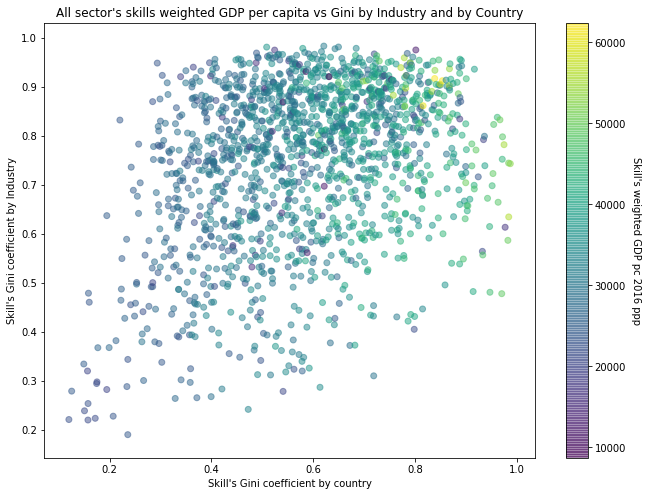

In [37]:
x, xlab = (dfAll['skillGiniCountry'], "Skill's Gini coefficient by country")
y, ylab = (dfAll['skillGiniIndustry'], "Skill's Gini coefficient by Industry")
z, zlab = (dfAll['gdpPcPpp2016'], "Skill's weighted GDP pc 2016 ppp")

fig, ax = plt.subplots(1, figsize=(11, 8))

image = ax.scatter(x, y, alpha=0.5,
          c=z, cmap='viridis')
ax.set(xlabel=xlab,
      ylabel=ylab,
      title="All sector's skills weighted GDP per capita vs Gini by Industry and by Country")


cbar = fig.colorbar(image, ax=ax)
cbar.ax.get_yaxis().labelpad = 15
cbar.ax.set_ylabel(zlab, rotation=270)
fig.savefig('../04_shared/ginisGdpPlot_ginigdp_all.png',bbox_inches='tight')
plt.show()

In [22]:
df = pd.merge(giniCoeffCountry.set_index('std_skill_name'), 
              pd.DataFrame(giniCoeff).rename(columns={0 : 'skillGiniIndustry'}), 
              left_index=True, right_index=True, how='inner')
df = pd.merge(df, 
              pd.DataFrame(skillGdppcppp2016).rename(columns={0 : 'gdpPcPpp2016'}),
              left_index=True, right_index=True, how='inner')
df = df.loc[df.index.isin(subsetSkills['std_skill_name'])]


[Text(0,0.5,"Skill's weighted GDP pc 2016 ppp"),
 Text(0.5,0,"Skill's Gini coefficient by Industry"),
 Text(0.5,1,"Knowledge sector's skills weighted GDP per capita vs Gini by Industry and by Country")]

Text(0,0.5,"Skill's Gini coefficient by country")

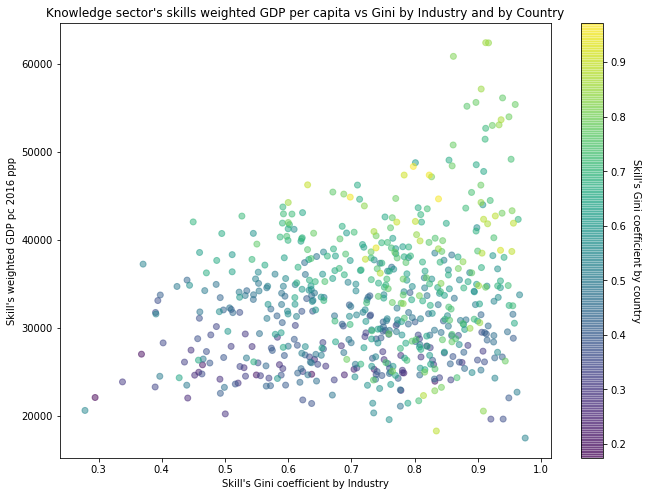

In [23]:
x, xlab = (df['skillGiniIndustry'], "Skill's Gini coefficient by Industry")
y, ylab = (df['gdpPcPpp2016'], "Skill's weighted GDP pc 2016 ppp")
z, zlab = (df['skillGiniCountry'], "Skill's Gini coefficient by country")

fig, ax = plt.subplots(1, figsize=(11, 8))

image = ax.scatter(x, y, alpha=0.5,
          c=z, cmap='viridis')
ax.set(xlabel=xlab,
      ylabel=ylab,
      title="Knowledge sector's skills weighted GDP per capita vs Gini by Industry and by Country")


cbar = fig.colorbar(image, ax=ax)
cbar.ax.get_yaxis().labelpad = 15
cbar.ax.set_ylabel(zlab, rotation=270)
fig.savefig('../04_shared/ginisGdpPlot_countrybar_knowledge.png',bbox_inches='tight')
plt.show()

[Text(0,0.5,"Skill's weighted GDP pc 2016 ppp"),
 Text(0.5,0,"Skill's Gini coefficient by country"),
 Text(0.5,1,"Knowledge sector's skills weighted GDP per capita vs Gini by Industry and by Country")]

Text(0,0.5,"Skill's Gini coefficient by Industry")

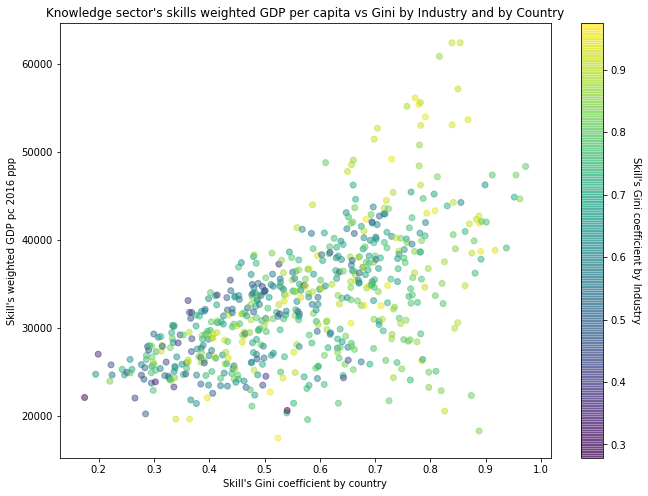

In [24]:
x, xlab = (df['skillGiniCountry'], "Skill's Gini coefficient by country")
y, ylab = (df['gdpPcPpp2016'], "Skill's weighted GDP pc 2016 ppp")
z, zlab = (df['skillGiniIndustry'], "Skill's Gini coefficient by Industry")

fig, ax = plt.subplots(1, figsize=(11, 8))

image = ax.scatter(x, y, alpha=0.5,
          c=z, cmap='viridis')
ax.set(xlabel=xlab,
      ylabel=ylab,
      title="Knowledge sector's skills weighted GDP per capita vs Gini by Industry and by Country")


cbar = fig.colorbar(image, ax=ax)
cbar.ax.get_yaxis().labelpad = 15
cbar.ax.set_ylabel(zlab, rotation=270)
fig.savefig('../04_shared/ginisGdpPlot_giniindustrybar_knowledge.png',bbox_inches='tight')
plt.show()

[Text(0,0.5,"Skill's Gini coefficient by Industry"),
 Text(0.5,0,"Skill's Gini coefficient by country"),
 Text(0.5,1,"Knowledge sector's skills weighted GDP per capita vs Gini by Industry and by Country")]

Text(0,0.5,"Skill's weighted GDP pc 2016 ppp")

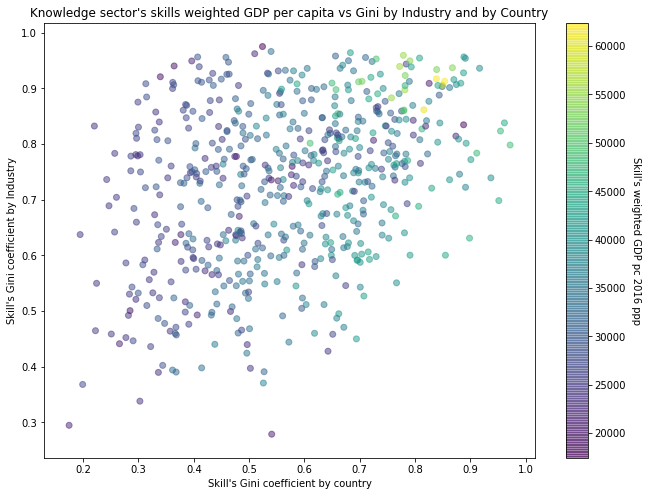

In [26]:
x, xlab = (df['skillGiniCountry'], "Skill's Gini coefficient by country")
y, ylab = (df['skillGiniIndustry'], "Skill's Gini coefficient by Industry")
z, zlab = (df['gdpPcPpp2016'], "Skill's weighted GDP pc 2016 ppp")

fig, ax = plt.subplots(1, figsize=(11, 8))

image = ax.scatter(x, y, alpha=0.5,
          c=z, cmap='viridis')
ax.set(xlabel=xlab,
      ylabel=ylab,
      title="Knowledge sector's skills weighted GDP per capita vs Gini by Industry and by Country")


cbar = fig.colorbar(image, ax=ax)
cbar.ax.get_yaxis().labelpad = 15
cbar.ax.set_ylabel(zlab, rotation=270)
fig.savefig('../04_shared/ginisGdpPlot_ginigdpbar_knowledge.png',bbox_inches='tight')
plt.show()